In [300]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [301]:
# 1. Obtenção dos Dados
# Usando 'period' para pegar os dados dos últimos 2 anos
dados = pd.read_csv('Dados Históricos - Ibovespa.csv')

dados.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,11.07.2025,136.187,136.742,136.742,135.528,"7,40M","-0,41%"
1,10.07.2025,136.743,137.472,137.472,136.014,"9,57M","-0,54%"
2,09.07.2025,137.481,139.303,139.331,137.299,"7,58B","-1,31%"
3,08.07.2025,139.303,139.491,139.591,138.770,"6,75B","-0,13%"
4,07.07.2025,139.490,141.265,141.342,139.295,"6,12B","-1,26%"


In [302]:
dados['Data'] = pd.to_datetime(dados['Data'])
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630 entries, 0 to 629
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Data      630 non-null    datetime64[ns]
 1   Último    630 non-null    float64       
 2   Abertura  630 non-null    float64       
 3   Máxima    630 non-null    float64       
 4   Mínima    630 non-null    float64       
 5   Vol.      630 non-null    object        
 6   Var%      630 non-null    object        
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 34.6+ KB


/var/folders/2z/l107wq8j77x68_6h4jnpgh440000gn/T/ipykernel_13961/1919189048.py:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  dados['Data'] = pd.to_datetime(dados['Data'])


In [303]:
def converter_volume_simples(valor):
    # Deixa tudo maiúsculo, troca vírgula por ponto e remove espaços
    valor_str = str(valor).upper().replace(',', '.').strip()
    
    if 'B' in valor_str:
        return int(float(valor_str.replace('B', '')) * 1_000_000_000)
    elif 'M' in valor_str:
        return int(float(valor_str.replace('M', '')) * 1_000_000)
    else:
        # Se não tiver letra, apenas converte para número
        return int(float(valor_str))

# 2. Aplique a função diretamente na coluna 'Volume'
dados['Vol.'] = dados['Vol.'].apply(converter_volume_simples)

dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630 entries, 0 to 629
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Data      630 non-null    datetime64[ns]
 1   Último    630 non-null    float64       
 2   Abertura  630 non-null    float64       
 3   Máxima    630 non-null    float64       
 4   Mínima    630 non-null    float64       
 5   Vol.      630 non-null    int64         
 6   Var%      630 non-null    object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 34.6+ KB


In [304]:
dados['Var%'] = pd.to_numeric(dados['Var%'].str.replace('%', '').str.replace(',', '.')) / 100

dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630 entries, 0 to 629
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Data      630 non-null    datetime64[ns]
 1   Último    630 non-null    float64       
 2   Abertura  630 non-null    float64       
 3   Máxima    630 non-null    float64       
 4   Mínima    630 non-null    float64       
 5   Vol.      630 non-null    int64         
 6   Var%      630 non-null    float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 34.6 KB


In [305]:
# 2. Engenharia de Atributos para Classificação

# Criando a variável-alvo (Target)
# 1 se o preço de fechamento de amanhã for MAIOR que o de hoje, 0 caso contrário
dados['Target'] = (dados['Último'].shift(-1) > dados['Último']).astype(int)

# Remover a última linha que terá um 'Target' NaN
dados.dropna(inplace=True)

In [306]:
# 3. Criação das Variáveis Preditivas (Features)

# Lags (preços dos dias anteriores)
for i in range(1, 6):
    dados[f'Lag_{i}'] = dados['Último'].shift(i)

# Médias Móveis
dados['SMA_10'] = dados['Último'].rolling(window=10).mean()
dados['SMA_30'] = dados['Último'].rolling(window=30).mean()

# Volatilidade (desvio padrão dos retornos em uma janela)
# dados['Volatility_10'] = dados['Daily_Return'].rolling(window=10).std()

# Remover linhas com NaN gerados pelas features
dados.dropna(inplace=True)

print("\n--- Dados Finais com Features ---")
dados


--- Dados Finais com Features ---


,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%,Target,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,SMA_10,SMA_30
29,2025-05-30,137.027,138.546,138.637,136.726,15140000000,-0.0109,1,136.787,137.546,137.002,136.236,136.102,136.7763,137.707300
30,2025-05-29,138.534,138.869,139.108,137.993,8830000000,-0.0025,1,137.027,136.787,137.546,137.002,136.236,136.8497,137.785533
31,2025-05-28,138.888,139.541,139.547,138.580,9730000000,-0.0047,1,138.534,137.027,136.787,137.546,137.002,137.0257,137.857033
32,2025-05-27,139.541,138.136,140.382,138.136,11190000000,0.0102,0,138.888,138.534,137.027,136.787,137.546,137.3362,137.925700
33,2025-05-26,138.136,137.824,138.800,137.795,5550000000,0.0023,0,139.541,138.888,138.534,137.027,136.787,137.5799,137.886800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
625,2023-06-01,108.964,107.642,109.433,107.642,12630000,0.0123,0,109.130,110.817,112.517,111.850,110.916,110.9996,110.760767
626,2023-05-01,107.641,105.336,107.743,105.333,15510000,0.0219,0,108.964,109.130,110.817,112.517,111.850,110.4715,110.684100
627,2023-04-01,105.334,104.167,105.627,103.915,14450000,0.0112,0,107.641,108.964,109.130,110.817,112.517,109.7821,110.541900
628,2023-03-01,104.166,106.377,106.684,103.852,14470000,-0.0208,1,105.334,107.641,108.964,109.130,110.817,109.0548,110.419133


In [307]:
# 4. Preparação para o Modelo
features = [col for col in dados.columns if col not in ['Data','Target']]
X = dados[features]
y = dados['Target']

# Divisão cronológica dos dados (80% treino, 20% teste)
tamanho_treino = int(len(dados) * 0.8)
X_treino, X_teste = X[:tamanho_treino], X[tamanho_treino:]
y_treino, y_teste = y[:tamanho_treino], y[tamanho_treino:]

print(f"\nTamanho do conjunto de Treino: {len(X_treino)} amostras")
print(f"Tamanho do conjunto de Teste: {len(X_teste)} amostras")


Tamanho do conjunto de Treino: 480 amostras
Tamanho do conjunto de Teste: 121 amostras


In [308]:
# 5. Treinamento do Modelo
# RandomForestClassifier para problemas de classificação
modelo = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
modelo.fit(X_treino, y_treino)

RandomForestClassifier(n_jobs=-1, random_state=42)


--- Resultados da Avaliação ---
Acurácia do Modelo: 99.17%

Relatório de Classificação:
                  precision    recall  f1-score   support

Caiu/Manteve (0)       1.00      0.98      0.99        63
       Subiu (1)       0.98      1.00      0.99        58

        accuracy                           0.99       121
       macro avg       0.99      0.99      0.99       121
    weighted avg       0.99      0.99      0.99       121


Matriz de Confusão:


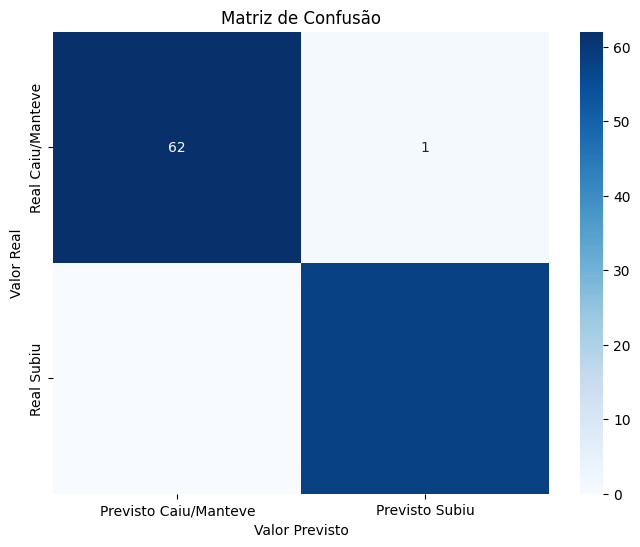

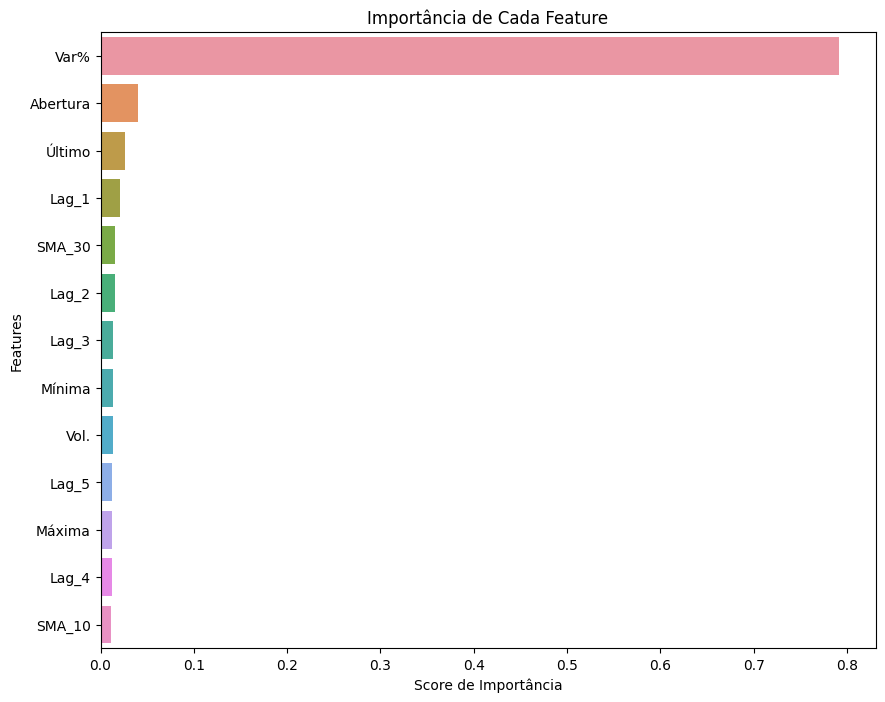

In [309]:
# 6. Avaliação do Desempenho
previsoes = modelo.predict(X_teste)

# Calcular a acurácia
acuracia = accuracy_score(y_teste, previsoes)
print(f"\n--- Resultados da Avaliação ---")
print(f"Acurácia do Modelo: {acuracia:.2%}")

# Exibir o Relatório de Classificação
print("\nRelatório de Classificação:")
# target_names mapeia os valores 0 e 1 para rótulos mais claros
print(classification_report(y_teste, previsoes, target_names=['Caiu/Manteve (0)', 'Subiu (1)']))

# Exibir a Matriz de Confusão
print("\nMatriz de Confusão:")
cm = confusion_matrix(y_teste, previsoes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Previsto Caiu/Manteve', 'Previsto Subiu'],
            yticklabels=['Real Caiu/Manteve', 'Real Subiu'])
plt.ylabel('Valor Real')
plt.xlabel('Valor Previsto')
plt.title('Matriz de Confusão')
plt.show()

# Importância das Features
# Ver quais features o modelo considerou mais importantes para a decisão
importancias = pd.Series(modelo.feature_importances_, index=features).sort_values(ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x=importancias, y=importancias.index)
plt.title('Importância de Cada Feature')
plt.xlabel('Score de Importância')
plt.ylabel('Features')
plt.show()

In [310]:
dados

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%,Target,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,SMA_10,SMA_30
29,2025-05-30,137.027,138.546,138.637,136.726,15140000000,-0.0109,1,136.787,137.546,137.002,136.236,136.102,136.7763,137.707300
30,2025-05-29,138.534,138.869,139.108,137.993,8830000000,-0.0025,1,137.027,136.787,137.546,137.002,136.236,136.8497,137.785533
31,2025-05-28,138.888,139.541,139.547,138.580,9730000000,-0.0047,1,138.534,137.027,136.787,137.546,137.002,137.0257,137.857033
32,2025-05-27,139.541,138.136,140.382,138.136,11190000000,0.0102,0,138.888,138.534,137.027,136.787,137.546,137.3362,137.925700
33,2025-05-26,138.136,137.824,138.800,137.795,5550000000,0.0023,0,139.541,138.888,138.534,137.027,136.787,137.5799,137.886800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
625,2023-06-01,108.964,107.642,109.433,107.642,12630000,0.0123,0,109.130,110.817,112.517,111.850,110.916,110.9996,110.760767
626,2023-05-01,107.641,105.336,107.743,105.333,15510000,0.0219,0,108.964,109.130,110.817,112.517,111.850,110.4715,110.684100
627,2023-04-01,105.334,104.167,105.627,103.915,14450000,0.0112,0,107.641,108.964,109.130,110.817,112.517,109.7821,110.541900
628,2023-03-01,104.166,106.377,106.684,103.852,14470000,-0.0208,1,105.334,107.641,108.964,109.130,110.817,109.0548,110.419133


In [311]:
!pip install pandas_ta
!pip install yfinance

In [312]:
# IMportar biblioteca com indicadores 
import pandas_ta as ta
import yfinance as yf


# Adicionando um conjunto de indicadores técnicos populares com uma única linha de código
dados.ta.strategy("common", append=True)

# # Vamos adicionar mais alguns úteis individualmente
# dados.ta.macd(append=True) # Moving Average Convergence Divergence
# dados.ta.rsi(append=True)  # Relative Strength Index

# # Adicionar o contexto do mercado geral (Ibovespa)
# ibov = yf.download('^BVSP', period='2y', auto_adjust=True)
# # Calcular o retorno diário do Ibovespa e adicionar aos nossos dados
# dados['IBOV_Return'] = ibov['Close'].pct_change()

# # Remover as linhas com valores NaN que foram geradas
# dados.dropna(inplace=True)

# print("\n--- Colunas disponíveis após adicionar indicadores ---")
# print(dados.columns)

[X] Not an available strategy.


In [313]:
dados.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%,Target,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,SMA_10,SMA_30
29,2025-05-30,137.027,138.546,138.637,136.726,15140000000,-0.0109,1,136.787,137.546,137.002,136.236,136.102,136.7763,137.707300
30,2025-05-29,138.534,138.869,139.108,137.993,8830000000,-0.0025,1,137.027,136.787,137.546,137.002,136.236,136.8497,137.785533
31,2025-05-28,138.888,139.541,139.547,138.580,9730000000,-0.0047,1,138.534,137.027,136.787,137.546,137.002,137.0257,137.857033
32,2025-05-27,139.541,138.136,140.382,138.136,11190000000,0.0102,0,138.888,138.534,137.027,136.787,137.546,137.3362,137.925700
33,2025-05-26,138.136,137.824,138.800,137.795,5550000000,0.0023,0,139.541,138.888,138.534,137.027,136.787,137.5799,137.886800
